## Scene Recognition (Scene-XAI)  
Dataset : https://xaidataset.github.io/dataset/

In [1]:
# import modules

import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from pathlib import Path
from tqdm import tqdm
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
# Load and organize image data
def load_dataset(image_dir):
    """
    Creates a DataFrame containing file paths and their respective labels.

    Args:
        image_dir: Path to the directory containing images.

    Returns:
        DataFrame with 'Filepath' and 'Label' columns.
    """
    image_files = list(Path(image_dir).glob('**/*.jpg'))
    labeled_files = [(str(file), file.parent.name) for file in image_files if file.parent.name]
    filepaths, labels = zip(*labeled_files)
    dataset = pd.DataFrame({'Filepath': filepaths, 'Label': labels}).sample(frac=1, random_state=42).reset_index(drop=True)
    return dataset
    
# Directory for images
image_directory = '/Users/belli/Documents/GitHub/XAI/places/image'
dataframe = load_dataset(image_directory)

In [3]:
# Display basic dataset information
print(f"Number of images: {len(dataframe)}")
print(f"Unique labels: {dataframe['Label'].nunique()}")
print(f"Labels: {dataframe['Label'].unique()}")

Number of images: 5000
Unique labels: 2
Labels: ['nature' 'urban']


There are 5000 images and 2 labels which are named 'nature' and 'urban'.

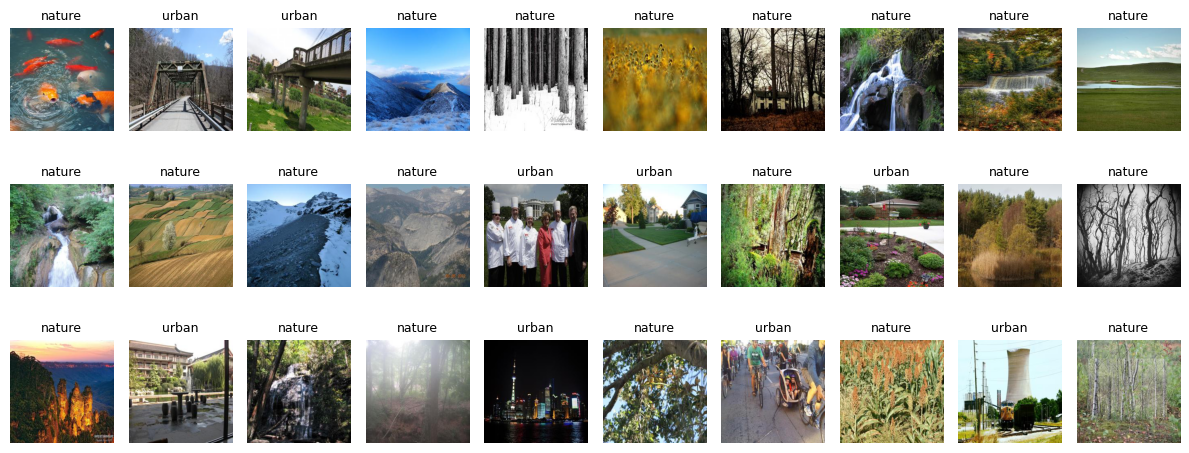

In [4]:
# Visualize some images from the dataset
def plot_image_samples(data, grid_rows=3, grid_cols=10):
    """
    Visualize sample images from the dataset with their labels.

    Args:
        data: DataFrame containing file paths and labels.
        grid_rows: Number of rows in the image grid.
        grid_cols: Number of columns in the image grid.
    """
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 5))
    for ax, (_, row) in zip(axes.flatten(), data.iterrows()):
        img = plt.imread(row['Filepath'])
        ax.imshow(img)
        ax.set_title(row['Label'], fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_image_samples(dataframe)

There are some images which are classified by two labels.

In [5]:
# Split dataset into training and testing sets
train_df, test_df = train_test_split(dataframe, test_size=0.1, random_state=42)

In [6]:
# Define data generators
def prepare_generators(train_data, test_data, image_size=(150, 150), batch_size=32):
    """
    Set up data generators for training, validation, and testing.

    Args:
        train_data: DataFrame for training data.
        test_data: DataFrame for testing data.
        image_size: Dimensions for resizing images.
        batch_size: Number of samples per batch.

    Returns:
        Tuple of training, validation, and testing generators.
    """
    data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen = data_generator.flow_from_dataframe(
        dataframe=train_data,
        x_col='Filepath',
        y_col='Label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=42
    )
    val_gen = data_generator.flow_from_dataframe(
        dataframe=train_data,
        x_col='Filepath',
        y_col='Label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=42
    )
    test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=test_data,
        x_col='Filepath',
        y_col='Label',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen = prepare_generators(train_df, test_df)

Found 3600 validated image filenames belonging to 2 classes.
Found 900 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


We build a data generator to efficiently manage data.

In [7]:
# Build a CNN model
def simple_cnn(input_shape=(150, 150, 3), num_classes=2):
    """
    Create and compile a basic CNN model.

    Args:
        input_shape: Shape of the input images.
        num_classes: Number of output categories.

    Returns:
        Compiled CNN model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# Train the CNN
cnn_model = simple_cnn(num_classes=len(train_gen.class_indices))
cnn_model.summary()
cnn_model.fit(train_gen, validation_data=val_gen, epochs=10)

C:\Users\belli\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,636,610 (40.58 MB)

 Trainable params: 10,636,610 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


C:\Users\belli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.5955 - loss: 1.3828 - val_accuracy: 0.7000 - val_loss: 0.5666
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.7431 - loss: 0.5190 - val_accuracy: 0.7178 - val_loss: 0.5719
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.8027 - loss: 0.4448 - val_accuracy: 0.7433 - val_loss: 0.5610
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.8857 - loss: 0.2817 - val_accuracy: 0.7400 - val_loss: 0.6524
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9372 - loss: 0.1759 - val_accuracy: 0.7478 - val_loss: 0.7110
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9793 - loss: 0.0876 - val_accuracy: 0.7378 - val_loss: 0.8963
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9888 - loss: 0.0395 - val_accuracy: 0.7200 - val_loss: 1.1277
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9960 - loss: 0.0199 - val

### CNN model result

The accuracy of the CNN model is high, almost close to 1.

1. Conv2D
- Extracts features from the input image.
- Has 896 trainable parameters.
- Input size was (150, 150, 3), reduced to (148, 148, 32) after applying a (3, 3) filter.

2. MaxPooling2D
- Downsamples feature maps, reducing computational cost and emphasizing features.
- Uses a (2, 2) pooling size, halving the input size to (74, 74, 32).
- No trainable parameters.

3. Conv2D (conv2d_1)
- Extracts more complex features.
- Uses 64 filters, resulting in 18,496 trainable parameters.
- Output size is (72, 72, 64) after applying a (3, 3) filter.
  
4. MaxPooling2D (max_pooling2d_1)
- Similar to layer 2, downsamples feature maps.
- Output size is (36, 36, 64) using a (2, 2) pooling size.
- No trainable parameters.
  
5. Flatten
- Converts the 2D feature maps into a 1D vector for the dense layer.
- Output size is 82,944, with no trainable parameters.
  
6. Dense
- Learns high-level features.
- Output size is 128, with 10,616,960 trainable parameters.
  
7. Dense (dense_1)
- Output layer for binary classification.
- Output size is 2, with 258 trainable parameters.

The total number of parameters and trainable parameters are equal, indicating that all layers are trainable.


### Reasons for Choosing Grad-CAM and LIME

1. Grad-CAM (Gradient-weighted Class Activation Mapping)
Grad-CAM provides a visual explanation of which regions of an input image were most important for a classification decision made by a deep learning model. It is intuitive and optimized for deep learning image models, making it easy to obtain visual explanations.

2. LIME (Local Interpretable Model-Agnostic Explanations)
LIME is a model-agnostic method that analyzes why a model classified a particular image. It works independently of the model's complexity, making it applicable to a wide range of models and providing local explanations.?

### Grad-CAM

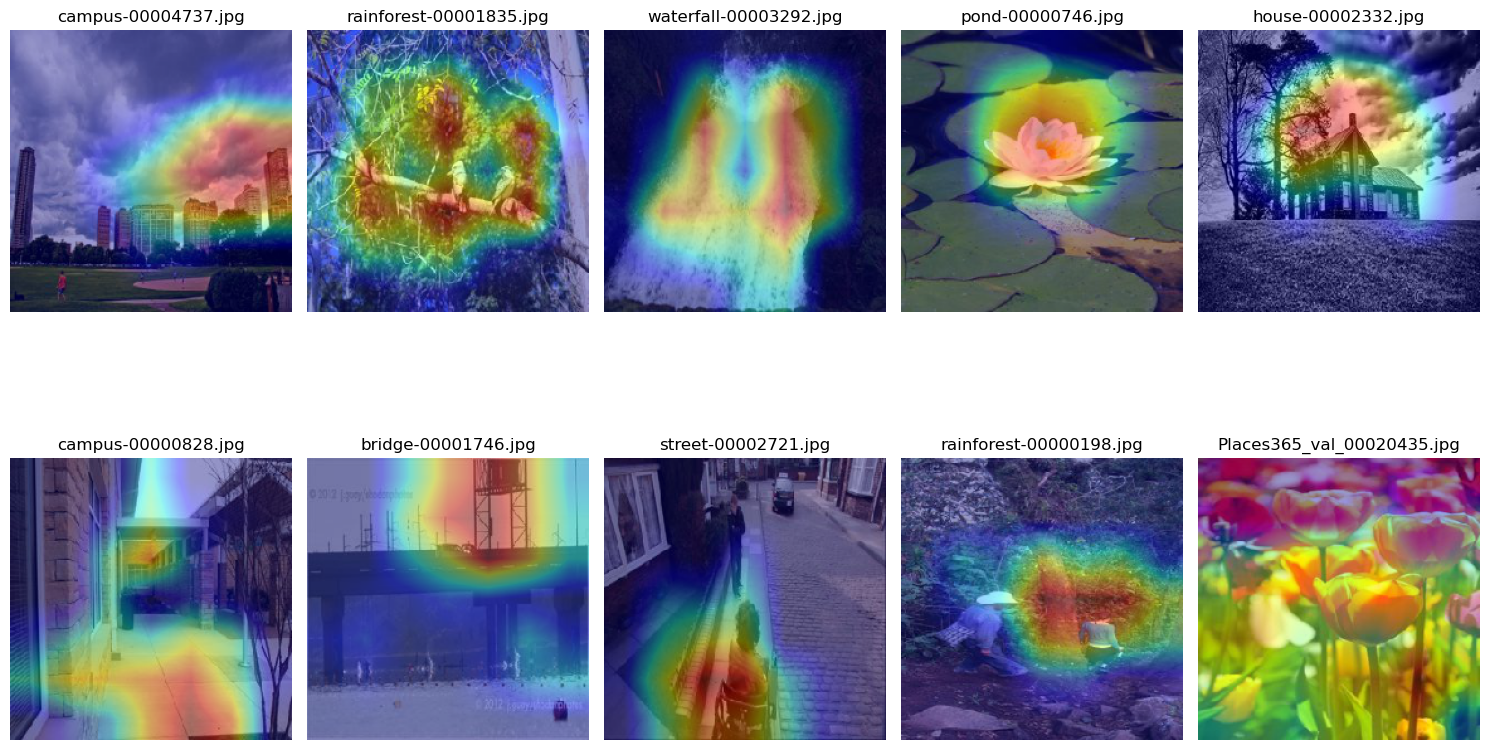

In [9]:
# Grad-CAM (1)

def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Grad-CAM Visualization Function
def display_grad_cam(image_path, model, layer_name, class_idx=None):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap = grad_cam(model, img_array, layer_name, class_idx)

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img

# Randomly Selecting Images for Grad-CAM and Visualization
def random_grad_cam(folder_path, model, layer_name, num_images=10):
    # Exploring the 'nature' and 'urban' Folders
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # Getting All Image Files from Both Folders
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # Combining Images from Both Folders and Random Sampling
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Running Grad-CAM and Visualization
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img = display_grad_cam(image_path, model, layer_name)
        plt.subplot(2, 5, i + 1)  # 2X5 subplot
        plt.imshow(overlayed_img)
        plt.title(os.path.basename(image_path))  # show file name
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pre-trained Model and Layer Name
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# Execution: 'image' Folder Path
folder_path = '/Users/belli/Documents/GitHub/XAI/places/image'
random_grad_cam(folder_path, model, layer_name, num_images=10)


The images were not classified as either 'nature' or 'urban'. This is because the VGG16 model was trained on ImageNet class labels. Therefore, we need to reclassify the images into 'nature' or 'urban' categories and display the corresponding accuracy.

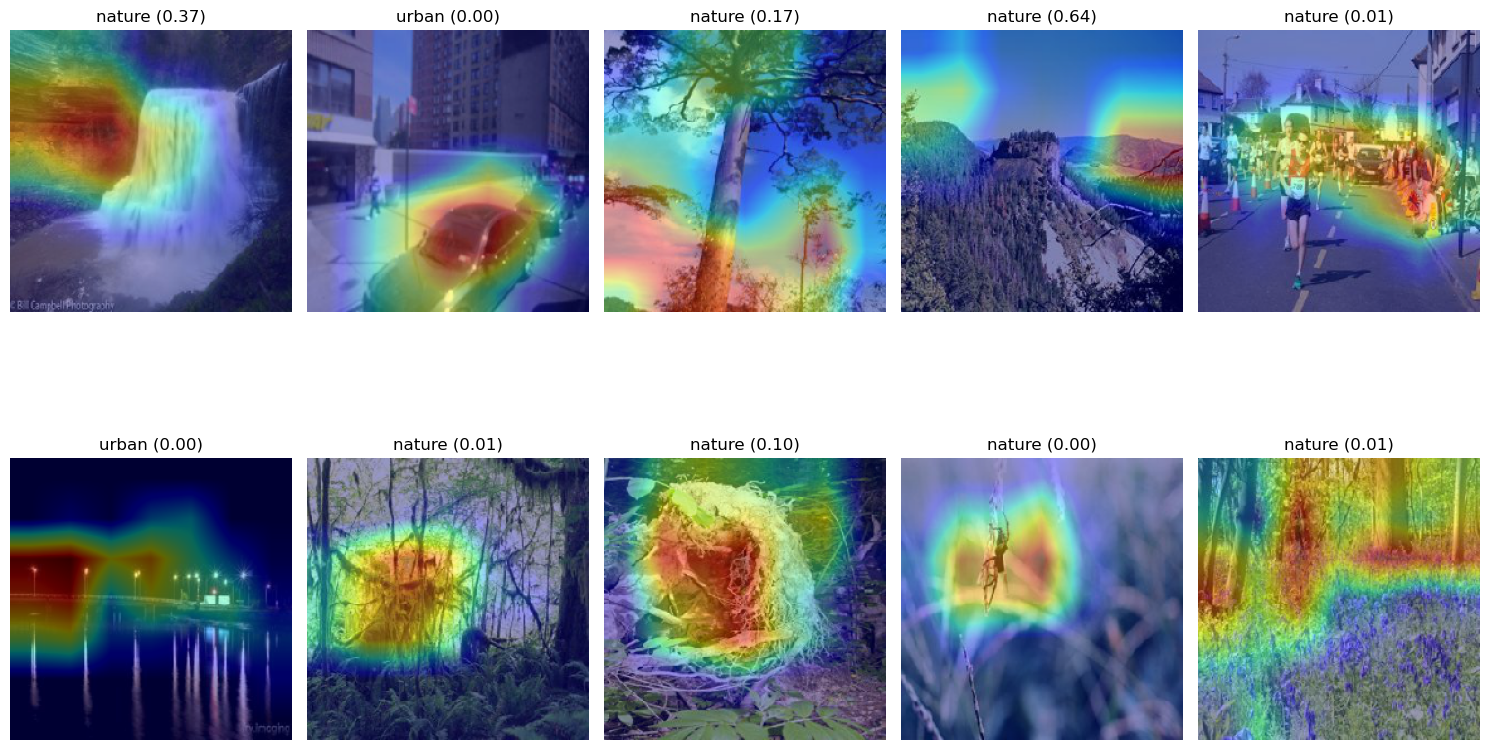

In [10]:
# Grad-CAM (2)
# Performs Grad-CAM for urban/nature binary classification

def grad_cam(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()

# Grad-CAM visualization function
def display_grad_cam(image_path, model, layer_name, urban_classes, nature_classes):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    heatmap, predictions = grad_cam(model, img_array, layer_name)

    # Decoding predictions (ImageNet classes)
    decoded_preds = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=5)
    pred_label = decoded_preds[0][0][1]  # name of class
    pred_confidence = decoded_preds[0][0][2]  # probability

    # Urban/nature classification
    urban_score = sum(predictions[0, urban_classes])
    nature_score = sum(predictions[0, nature_classes])
    final_label = "urban" if urban_score > nature_score else "nature"
    final_confidence = max(urban_score, nature_score)

    # Resize heatmap
    heatmap = tf.image.resize(heatmap[..., tf.newaxis], (224, 224)).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.clip(heatmap, 0, 1)

    # Load original imageb
    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_img).astype(np.uint8)

    # Apply colormap
    colormap = plt.cm.jet(heatmap)[:, :, :3]
    colormap = np.uint8(255 * colormap)

    # Overlay original image with colormap
    overlayed_img = 0.6 * original_img + 0.4 * colormap
    overlayed_img = np.uint8(overlayed_img)

    return overlayed_img, final_label, final_confidence

# Randomly select images and perform Grad-CAM visualization
def random_grad_cam(folder_path, model, layer_name, urban_classes, nature_classes, num_images=10):
    # Explore nature/urban folders
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # Get all image files from both folders
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # Combine images from both folders and perform random sampling
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Perform Grad-CAM and visualization
    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(selected_images):
        overlayed_img, final_label, final_confidence = display_grad_cam(
            image_path, model, layer_name, urban_classes, nature_classes)
        plt.subplot(2, 5, i + 1)  # 2X5 subplot
        plt.imshow(overlayed_img)
        plt.title(f"{final_label} ({final_confidence:.2f})")  # urban/nature and probability
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pre-trained model and layer name
model = tf.keras.applications.MobileNetV2(weights="imagenet")
layer_name = "Conv_1_bn"

# Urban/nature class mapping (ImageNet class indices)
urban_classes = [555, 834, 835, 873]  # e.g., dam, building
nature_classes = [970, 972, 976, 978]  # e.g., valley, forest

# Execution: 'image' folder path
folder_path = '/Users/belli/Documents/GitHub/XAI/places/image'
random_grad_cam(folder_path, model, layer_name, urban_classes, nature_classes, num_images=10)


Images classified as 'urban' showed a focus on specific features such as windows, doors, spires, signs, human limbs, wheelchair, car and bridges. 
And images classified as 'nature' highlighted elements like leaves, tree trunks, water, flowers, insect, mountains, rocks, and fields.

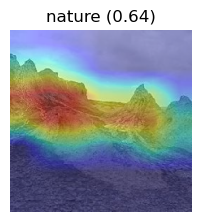

In [11]:
# Randomly select images and perform Grad-CAM visualization
def random_grad_cam_filtered(folder_path, model, layer_name, urban_classes, nature_classes, num_images=10, confidence_threshold=0.5):
    """
    Randomly select images and perform Grad-CAM visualization, filtering by confidence threshold.
    Args:
        folder_path: Path to image folder containing 'nature' and 'urban'.
        model: Pre-trained Keras model.
        layer_name: Target layer for Grad-CAM.
        urban_classes: List of class indices for urban category.
        nature_classes: List of class indices for nature category.
        num_images: Number of images to process.
        confidence_threshold: Minimum confidence required for visualization.
    """
    # Explore nature/urban folders
    nature_path = os.path.join(folder_path, "nature")
    urban_path = os.path.join(folder_path, "urban")
    
    # Get all image files from both folders
    nature_images = [os.path.join(nature_path, img) for img in os.listdir(nature_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    urban_images = [os.path.join(urban_path, img) for img in os.listdir(urban_path) if img.lower().endswith(('jpg', 'jpeg', 'png'))]
    
    # Combine images from both folders and perform random sampling
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))
    
    # Perform Grad-CAM and filter by confidence
    filtered_results = []
    for image_path in selected_images:
        overlayed_img, final_label, final_confidence = display_grad_cam(
            image_path, model, layer_name, urban_classes, nature_classes)
        
        # Filter by confidence threshold
        if final_confidence >= confidence_threshold:
            filtered_results.append((overlayed_img, final_label, final_confidence))
    
    # Display filtered results
    if not filtered_results:
        print(f"No images met the confidence threshold of {confidence_threshold:.2f}.")
        return

    plt.figure(figsize=(10, 5))
    for i, (overlayed_img, final_label, final_confidence) in enumerate(filtered_results):
        plt.subplot(2, 5, i + 1)  # Adjust subplot size as needed
        plt.imshow(overlayed_img)
        plt.title(f"{final_label} ({final_confidence:.2f})")  # Display label and confidence
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show only filtered Grad-CAM results
folder_path = '/Users/belli/Documents/GitHub/XAI/places/image'
random_grad_cam_filtered(
    folder_path, 
    model, 
    layer_name, 
    urban_classes, 
    nature_classes, 
    num_images=10, 
    confidence_threshold=0.5
)

A confidence threshold of 0.5 was employed to filter out predictions with low probability, thereby enhancing the overall reliability of the classification results.

## LIME

Processing image 1: /Users/belli/Documents/GitHub/XAI/places/image\nature\pond-00000002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

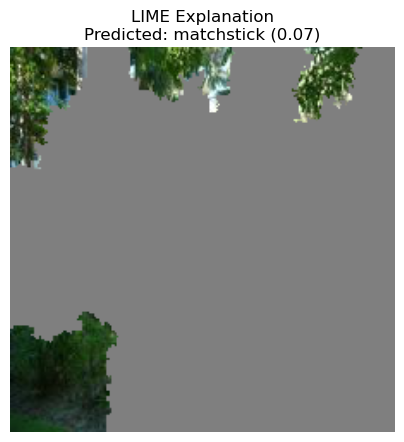

Processing image 2: /Users/belli/Documents/GitHub/XAI/places/image\urban\house-00002233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

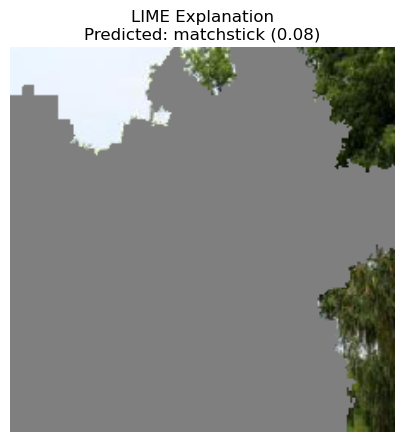

Processing image 3: /Users/belli/Documents/GitHub/XAI/places/image\urban\house-00001021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

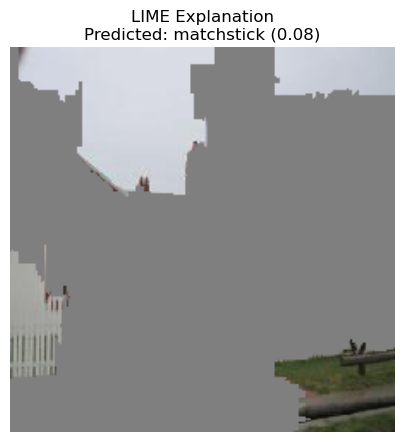

Processing image 4: /Users/belli/Documents/GitHub/XAI/places/image\nature\Places365_val_00002113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

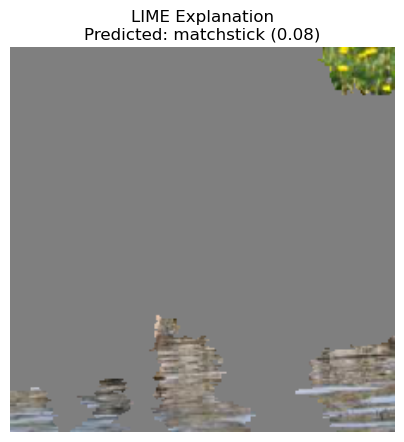

Processing image 5: /Users/belli/Documents/GitHub/XAI/places/image\urban\driveway-00004637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

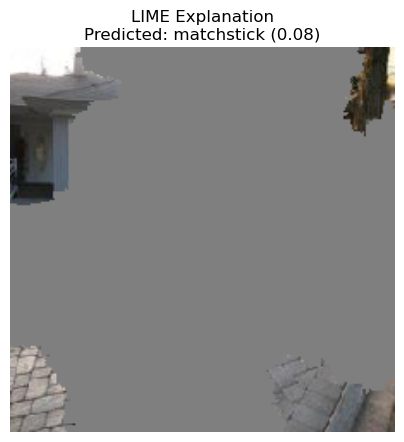

In [13]:
# lIME(1)

def explain_with_lime(model, img_path):
    """
    Generates and visualizes an explanation for an image using LIME.

    Args:
        model: A pre-trained Keras model (e.g., VGG16).
        img_path: The path to the image.
    """

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Scale to [0, 1]
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

    # Make a prediction with the model
    preds = model.predict(img_array)
    decoded_preds = decode_predictions(preds, top=2)[0]  # Decode top 2 predictions
    pred_label = decoded_preds[0][1]  # Class name with the highest probability
    pred_confidence = decoded_preds[0][2]  # Probability of that class

    # Initialize LIME image explainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array[0],
        model.predict,
        top_labels=2,
        hide_color=0,  # Set the background to black
        num_samples=1000
    )

    # Get the explanation results
    label = explanation.top_labels[0]  # Select the top label
    temp, mask = explanation.get_image_and_mask(
        label=label,
        positive_only=False,  # Show both positive and negative regions
        hide_rest=False  # Don't hide the background
    )

    # Combine the original image with the mask
    original_img = img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0  # Original image in [0, 1]
    mask = mask.astype(np.float32)  # Convert mask to float32
    mask = np.expand_dims(mask, axis=-1)  # Add a channel dimension (H, W) -> (H, W, 1)

    # Combine the mask and original image (show original image only in highlighted areas)
    highlighted_img = mask * original_img + (1 - mask) * 0.5  # Keep background at 50% brightness

    # Visualization
    plt.figure(figsize=(5, 5))  # Adjust output image size (5x5 inches)
    plt.imshow(highlighted_img, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'LIME Explanation\nPredicted: {pred_label} ({pred_confidence:.2f})')
    plt.show()

def random_lime(folder_path, model, num_images=5):
    """
    Randomly selects images from the given folder and runs LIME on them.

    Args:
        folder_path: The path to the image folder.
        model: A pre-trained Keras model (e.g., VGG16).
        num_images: Number of images to process.
    """
    nature_folder = os.path.join(folder_path, 'nature')
    urban_folder = os.path.join(folder_path, 'urban')

    # Collect image paths from nature and urban folders
    nature_images = [os.path.join(nature_folder, img) for img in os.listdir(nature_folder) if img.endswith(('.jpg', '.png'))]
    urban_images = [os.path.join(urban_folder, img) for img in os.listdir(urban_folder) if img.endswith(('.jpg', '.png'))]

    # Combine images from both folders and sample randomly
    all_images = nature_images + urban_images
    selected_images = random.sample(all_images, min(len(all_images), num_images))

    # Run LIME and visualize results
    for i, img_path in enumerate(selected_images):
        print(f"Processing image {i+1}: {img_path}")
        explain_with_lime(model, img_path)

# 1. Load a pre-trained model
model = VGG16(weights="imagenet")

# 2. Run: Specify the 'image' folder path
folder_path = '/Users/belli/Documents/GitHub/XAI/places/image'
random_lime(folder_path, model, num_images=5)

While features like leaves, fences, water, flowers, building columns, sidewalks, grass, waterfalls, building corners, and animal fur are identified as salient regions, all of these images were incorrectly classified as 'matchstick'. The model should be retrained to distinguish between 'nature' and 'urban' categories.

Processing image 1: /Users/belli/Documents/GitHub/XAI/places/image\urban\driveway-00002425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.076271996), ('n01930112', 'nematode', 0.04812909), ('n03666591', 'lighter', 0.030744122), ('n03196217', 'digital_clock', 0.029425448), ('n04286575', 'spotlight', 0.023466645)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

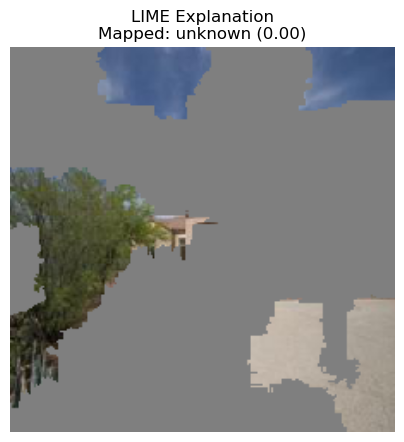

Processing image 2: /Users/belli/Documents/GitHub/XAI/places/image\nature\mountain-00001790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.07528499), ('n01930112', 'nematode', 0.048415095), ('n03666591', 'lighter', 0.03082761), ('n03196217', 'digital_clock', 0.029565295), ('n04286575', 'spotlight', 0.023871357)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

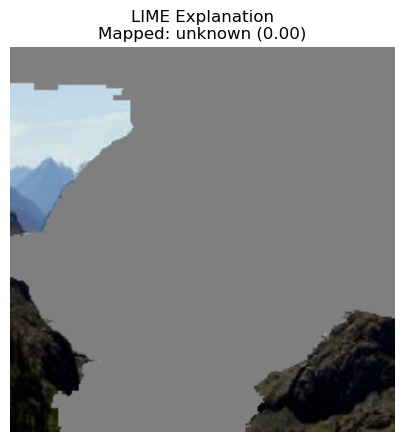

Processing image 3: /Users/belli/Documents/GitHub/XAI/places/image\nature\rainforest-00000198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.075410426), ('n01930112', 'nematode', 0.048531156), ('n03666591', 'lighter', 0.03050444), ('n03196217', 'digital_clock', 0.029563412), ('n04286575', 'spotlight', 0.023813868)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

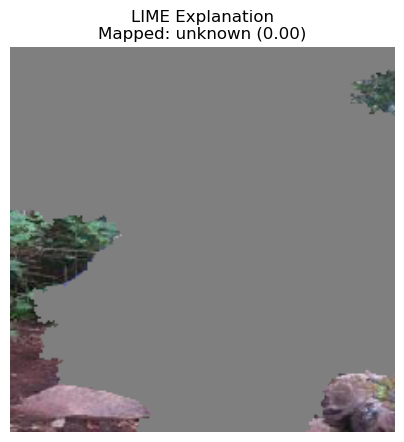

Processing image 4: /Users/belli/Documents/GitHub/XAI/places/image\urban\Places365_val_00009318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.07644327), ('n01930112', 'nematode', 0.0489881), ('n03666591', 'lighter', 0.03115811), ('n03196217', 'digital_clock', 0.029651653), ('n04286575', 'spotlight', 0.024178032)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

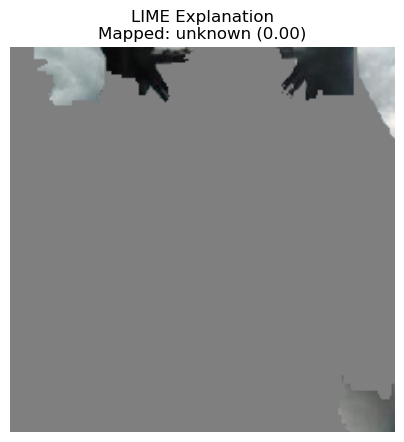

Processing image 5: /Users/belli/Documents/GitHub/XAI/places/image\urban\driveway-00000852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted: unknown (Confidence: 0.00)
Raw Predictions: [('n03729826', 'matchstick', 0.07625623), ('n01930112', 'nematode', 0.048746888), ('n03666591', 'lighter', 0.030686686), ('n03196217', 'digital_clock', 0.02973497), ('n04286575', 'spotlight', 0.02361123)]


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

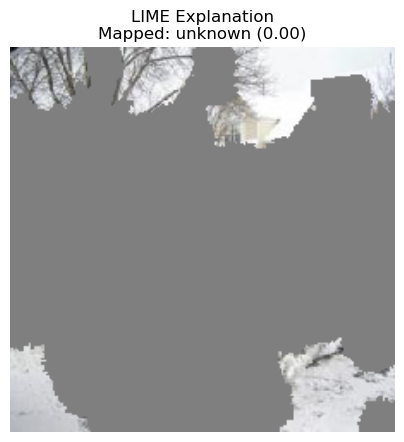

In [16]:
# LIME(2)

# Define labels for nature/urban categories
nature_labels = [
    "mountain", "valley", "volcano", "forest", "lakeside",
    "seashore", "ocean", "field", "desert", "park", "dam"
]
urban_labels = [
    "building", "street", "city", "castle", "tower",
    "skyscraper", "viaduct", "bridge", "palace", "stadium"
]

def map_to_custom_labels(decoded_preds):
    """
    Maps ImageNet predictions to custom nature/urban labels.
    """
    for pred in decoded_preds:
        label = pred[1].lower()  # Convert class name to lowercase
        if label in nature_labels:
            return "nature", pred[2]  # Return "nature" and probability
        elif label in urban_labels:
            return "urban", pred[2]  # Return "urban" and probability
    return "unknown", 0.0  # Return "unknown" if not matched

def explain_with_lime(model, img_path):
    """
    Generates and visualizes an explanation for an image using LIME.
    """
    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Scale to [0, 1]
        img_array = preprocess_input(img_array)  # Preprocess for VGG16
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        preds = model.predict(img_array)
        decoded_preds = decode_predictions(preds, top=5)[0]  # Decode top 5 predictions
        mapped_label, confidence = map_to_custom_labels(decoded_preds)  # Map to custom labels

        print(f"Predicted: {mapped_label} (Confidence: {confidence:.2f})")
        print(f"Raw Predictions: {decoded_preds}")

        # Initialize LIME image explainer
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            img_array[0],
            model.predict,
            top_labels=2,
            hide_color=0,  # Set background to black
            num_samples=1000
        )

        # Get explanation results
        label = explanation.top_labels[0]  # Select top label
        temp, mask = explanation.get_image_and_mask(
            label=label,
            positive_only=False,  # Show both positive and negative regions
            hide_rest=False  # Don't hide background
        )

        # Combine mask with original image
        original_img = img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0  # Original image in [0, 1]
        mask = mask.astype(np.float32)  # Convert mask to float32
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension (H, W) -> (H, W, 1)
        highlighted_img = mask * original_img + (1 - mask) * 0.5  # Keep background at 50% brightness

        # Visualize
        plt.figure(figsize=(5, 5))
        plt.imshow(highlighted_img, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'LIME Explanation\nMapped: {mapped_label} ({confidence:.2f})')
        plt.show()

    except Exception as e:
        print(f"Error processing image {img_path}: {e}")

def random_lime(folder_path, model, num_images=5):
    """
    Randomly selects images from a folder and generates LIME explanations.
    """
    nature_folder = os.path.join(folder_path, 'nature')
    urban_folder = os.path.join(folder_path, 'urban')

    # Collect image paths from nature and urban folders
    nature_images = [os.path.join(nature_folder, img) for img in os.listdir(nature_folder) if img.endswith(('.jpg', '.png'))]
    urban_images = [os.path.join(urban_folder, img) for img in os.listdir(urban_folder) if img.endswith(('.jpg', '.png'))]

    # Combine images from both folders and sample randomly
    all_images = nature_images + urban_images

    if not all_images:
        print("No images found in the specified folders.")
        return

    selected_images = random.sample(all_images, min(len(all_images), num_images))

    # Run LIME and visualize results
    for i, img_path in enumerate(selected_images):
        print(f"Processing image {i+1}: {img_path}")
        explain_with_lime(model, img_path)

# Load pre-trained model
model = VGG16(weights="imagenet")

# Run with 'image' folder
folder_path = '/Users/belli/Documents/GitHub/XAI/places/image'
random_lime(folder_path, model, num_images=5)

Despite dividing ImageNet class labels into 'nature' and 'urban' categories, all images were classified as 'unknown'. The model's accuracy was extremely low, approaching zero, indicating a failure to distinguish between the two categories.

Since only uncertain results were obtained with the LIME method, it can be said that the results of Grad-CAM showed better performance in image classification.

References

- Chat-GPT
- https://zeuskwon-ds.tistory.com/49
- https://velog.io/@tobigs_xai/1%EC%A3%BC%EC%B0%A8-%EB%8C%80%EB%A6%AC%EB%B6%84%EC%84%9DLIME